
# Lab: Cross-Validation and the Bootstrap

In this lab, we explore the resampling techniques covered in this chapter. Some of the commands in this lab may take a while to run on your computer.

## The Validation Set Approach

We explore the use of the validation set approach in order to estimate the test error rates that result from fitting various linear models on the `Auto` data set.

We will use pandas random state parameter to set the internal seed of the random number generator, so that results be reproducible.It is generally
a good idea to set a random seed when performing an analysis such as cross-validation that contains an
element of randomness, so that the results obtained can be reproduced precisely at a later time.

We begin by using the
`sample()` function to split the set of observations into two halves, by selecting a random subset of $196$ observations out of the original $392$ observations. We  refer
to these observations as the training set.

In [13]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
from sklearn.utils import resample
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold, LeaveOneOut
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import PolynomialFeatures

In [10]:
Auto = pd.read_csv('data/Auto.csv')
Auto.head()

,mpg,cylinders,displacement,horsepower,weight,acceleration,year,origin,name
0,18.0,8,307.0,130,3504,12.0,70,1,chevrolet chevelle malibu
1,15.0,8,350.0,165,3693,11.5,70,1,buick skylark 320
2,18.0,8,318.0,150,3436,11.0,70,1,plymouth satellite
3,16.0,8,304.0,150,3433,12.0,70,1,amc rebel sst
4,17.0,8,302.0,140,3449,10.5,70,1,ford torino


In [59]:
# Get X data matric and y target vector
X = Auto[['horsepower']].values
y = Auto['mpg'].values

# We will add square and cubic terms now, and use them later
X = PolynomialFeatures(10, include_bias=False).fit_transform(X)

# Use sklearn train test splitter
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.5, random_state=1)

In [60]:
# Fit linear model
lm = LinearRegression().fit(X_train[:, :1], y_train)

We now  use
 the `predict()` function to estimate the response for the test set, and
 we  use the `mean()` function to calculate the MSE of the $196$ observations in the test set.

In [61]:
np.mean((y_test - lm.predict(X_test[:, :1]))**2)

24.80212062059356

Therefore, the estimated test MSE for the linear regression fit is $24.80$. We can use the `PolynomialFeatures` function to estimate the test error for the quadratic and cubic regressions.

In [62]:
lm2 = LinearRegression().fit(X_train[:, :2], y_train)
np.mean((y_test - lm2.predict(X_test[:, :2]))**2)

18.848292603275652

In [63]:
lm3 = LinearRegression().fit(X_train[:, :3], y_train)
np.mean((y_test - lm3.predict(X_test[:, :3]))**2)

18.805111358604883

These error rates are $18.84$ and $18.80$, respectively.
If we choose a different training set instead, then we will obtain somewhat different errors on the validation set.

In [64]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.5, random_state=2)

lm = LinearRegression().fit(X_train[:, :1], y_train)
print(np.mean((y_test - lm.predict(X_test[:, :1]))**2))

lm2 = LinearRegression().fit(X_train[:, :2], y_train)
print(np.mean((y_test - lm2.predict(X_test[:, :2]))**2))

lm3 = LinearRegression().fit(X_train[:, :3], y_train)
print(np.mean((y_test - lm3.predict(X_test[:, :3]))**2))

23.442643969985728
18.550198801910305
18.59522229455449


Using this split of the observations into a training set and a validation set,
we find that the validation set error rates for the models with linear, quadratic, and cubic terms are $24.44$, $18.55$, and $18.59$, respectively.

These results are consistent with our previous findings: a model that predicts `mpg` using a quadratic function of `horsepower` performs better than a model that involves only a linear function of `horsepower`, and there is little evidence in favor of a model that uses a cubic function of `horsepower`.

## Leave-One-Out Cross-Validation

Automatic crossvalidation is not implemente neither in Scikit-Learn or Statmodels linear models. So we explicitly carry LOOCV now using the appropriate Scikit-Learn function.
The simplest way to use cross-validation is to call the `cross_val_score` helper function on the estimator and the dataset.
The `scoring` parameters defines which scoring function to use, and defaults to eachs estimator internal scoring function.
For linear regression the default scoring is done with the $R^2$ coefficient, here we perform the scoring with the mean squared error.
Since scoring functions in Scikit-Learn follow the convention that higher return values are better than lower return values, metrics which measure the distance between the model and the data, like `metrics.mean_squared_error`, are available as neg_mean_squared_error which return the negated value of the metric.

In [65]:
lm = LinearRegression()
cv_scores = cross_val_score(lm, X[:, :1], y, cv=LeaveOneOut(), scoring='neg_mean_squared_error')
print(f'Mean squared error: {abs(cv_scores.mean())} +- {cv_scores.std()}')

Mean squared error: 24.231513517929226 +- 36.797315036405344


Our cross-validation estimate for the test error is approximately $24.23$.

We can repeat this procedure for increasingly complex polynomial fits.
 To automate the process, we use a for loop to iteratively fits polynomial regressions for polynomials of order $i=1$ to $i=10$.

Mean squared error: 24.23 +- 36.80
Mean squared error: 19.25 +- 35.00
Mean squared error: 19.33 +- 35.77
Mean squared error: 19.42 +- 35.68
Mean squared error: 19.03 +- 35.32
Mean squared error: 18.98 +- 35.30
Mean squared error: 19.13 +- 35.27
Mean squared error: 19.22 +- 35.38
Mean squared error: 19.13 +- 35.44
Mean squared error: 18.95 +- 35.09


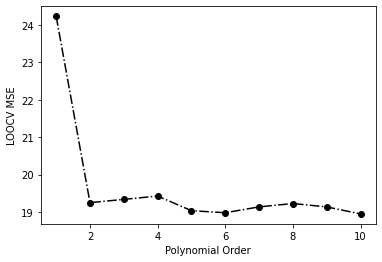

In [71]:
cv_error = []
for i in range(1, 11):
    cv_scores = cross_val_score(lm, X[:, :i], y, cv=LeaveOneOut(), scoring='neg_mean_squared_error')
    print(f'Mean squared error: {abs(cv_scores.mean()):0.2f} +- {cv_scores.std():0.2f}')
    cv_error.append(abs(cv_scores.mean()))

fig , ax = plt.subplots(figsize=(6,4))
ax.plot(range(1, 11), cv_error, linestyle = '-.', marker='o',color='k');
ax.set_xlabel('Polynomial Order');
ax.set_ylabel('LOOCV MSE');

As in Figure 5.4, we see a sharp drop in the estimated test MSE between the linear and quadratic fits, but then no clear improvement from using higher-order polynomials.

## $k$-Fold Cross-Validation

The `cross_val_score` function can also be used to implement $k$-fold CV. Below we use $cv=10$, a common choice for $k$, on the `Auto` data set.
We once again set a random seed and initialize a vector in which we will store the CV errors corresponding to the polynomial fits of orders one to ten.

Mean squared error: 24.18 +- 6.87
Mean squared error: 19.14 +- 6.67
Mean squared error: 19.16 +- 6.75
Mean squared error: 19.25 +- 6.57
Mean squared error: 18.90 +- 6.04
Mean squared error: 18.82 +- 6.03
Mean squared error: 18.96 +- 6.07
Mean squared error: 19.04 +- 6.21
Mean squared error: 18.97 +- 6.36
Mean squared error: 18.80 +- 6.33


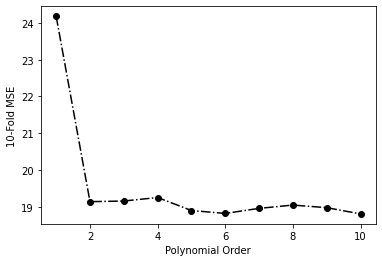

In [72]:
cv = KFold(10, shuffle=True, random_state=17)
cv_error = []
for i in range(1, 11):
    cv_scores = cross_val_score(lm, X[:, :i], y, cv=cv, scoring='neg_mean_squared_error')
    print(f'Mean squared error: {abs(cv_scores.mean()):0.2f} +- {cv_scores.std():0.2f}')
    cv_error.append(abs(cv_scores.mean()))

fig , ax = plt.subplots(figsize=(6,4))
ax.plot(range(1, 11), cv_error, linestyle = '-.', marker='o',color='k');
ax.set_xlabel('Polynomial Order');
ax.set_ylabel('10-Fold MSE');

Notice that the computation time is shorter than that of LOOCV.
(In principle, the computation time for LOOCV for a least squares linear model should be faster than for $k$-fold CV, due to the availability
of the formula ( 5.2) for LOOCV; however, unfortunately Scikit-Learn does not make use of this formula.)
We still see little evidence that using cubic or higher-order polynomial terms leads to lower test error than simply using a quadratic fit.

## The Bootstrap

We illustrate the use of the bootstrap in the simple example of Section 5.2, as well as on an example involving estimating the
accuracy of the linear regression model on the `Auto` data set.

### Estimating the Accuracy of a Statistic of Interest

One of the great advantages of the bootstrap approach is that it can be
applied in almost all situations. No complicated mathematical calculations
are required. Performing a bootstrap analysis in `Python` entails only two
steps. First, we must create a function that computes the statistic of
interest. Second, implement a `boot` function, to perform the bootstrap by repeatedly
sampling observations from the data set with replacement.

The `Portfolio` data set in the `ISLR2` package is simulated data of $100$ pairs of returns, generated in the fashion described in Section 5.2.
To illustrate the use of the bootstrap on this data, we must first
create a function, `alpha`, which takes as input the $(X,Y)$ data
as well as a vector indicating which observations should be used to
estimate $\alpha$. The function then outputs the estimate for $\alpha$
based on the selected observations.

In [76]:
# load the portfolio data set
portfolio = pd.read_csv('data/Portfolio.csv')
portfolio.head()

,X,Y
0,-0.895251,-0.234924
1,-1.562454,-0.885176
2,-0.417090,0.271888
3,1.044356,-0.734198
4,-0.315568,0.841983


In [97]:
# We first need a function aplha to return the alpha statistic eqn. 5.7 in the text
def alpha(df, indices):
    """ 
    Returns the alpha statistic for  the rows defined by indices from dataframe df.
    """
    # Get X, Y
    X = df.X[indices].values
    Y = df.Y[indices].values
    
    # np.cov returns full cov matrix we need [0][1] cov(x,y)
    return (np.var(Y) - np.cov(X,Y)[0][1])/(np.var(X) + np.var(Y) - 2*np.cov(X,Y)[0][1])

This function *returns*, or outputs, an  estimate for $\alpha$ based on applying ( 5.7) to the observations indexed by the argument `index`.
For instance, the following command tells `Python` to estimate $\alpha$ using
all $100$ observations.

In [98]:
alpha(portfolio, portfolio.index)

0.5766511516104116

The next command  uses the `sample()` function to randomly select
$100$ observations from the range $1$ to $100$, with replacement. This is equivalent
to constructing a new bootstrap data set and recomputing $\hat{\alpha}$
based on the new data set.

In [114]:
np.random.seed(7)
indices = np.random.choice(portfolio.index, 100, replace=True)
alpha(portfolio, indices)

0.5117744709121624

We can implement a bootstrap analysis by performing this command many times, recording all of
the corresponding estimates for $\alpha$, and computing the resulting
standard deviation.
However, the `boot()` function automates this approach. Below we produce $R=1,000$ bootstrap estimates for $\alpha$.


In [133]:
def boot(data, statsfunc, num_bootstrap_samples):
    """
    Returns the SE of the statistic returned by statsfunc when applied to data using num_bootstrap samples.
    """
    samples = []
    sample_size = len(data)
    for sample in range(num_bootstrap_samples):
        # apply our stats_func to generate a sample statistic
        indices = np.random.choice(data.index, sample_size, replace=True)
        samples.append(statsfunc(data, indices))
    # compute the std of the statistic samples
    se = np.std(samples, axis=0)
    
    print('\nBootstrapped Std. Error(s) =', se)

In [134]:
boot(portfolio, alpha, 1000)


Bootstrapped Std. Error(s) = 0.0910757862484383


The final output shows that using the original data, $\hat{\alpha}=0.576$,
and that the bootstrap estimate for ${\rm SE}(\hat{\alpha})$ is $0.092$.

### Estimating the Accuracy of a Linear Regression Model

The bootstrap approach can be used  to assess the
variability of the coefficient estimates and predictions from a statistical learning method. Here we use the bootstrap approach in order to assess the variability of
the estimates for $\beta_0$ and $\beta_1$, the intercept and slope terms for the linear regression model
that uses  `horsepower` to predict `mpg` in the `Auto` data set. We will compare the estimates obtained using the bootstrap to those obtained using the formulas
for ${\rm SE}(\hat{\beta}_0)$ and ${\rm SE}(\hat{\beta}_1)$ described
in Section 3.1.2.

We first create a simple function, `boot_fn()`, which takes in the
`Auto` data set as well as a set of indices for the observations, and
returns the intercept and slope estimates for the linear regression model. We then apply this function
to the full set of $392$ observations in order to compute the estimates of $\beta_0$ and $\beta_1$ on the entire data set using the usual linear regression coefficient estimate
formulas from Chapter 3.

In [117]:
import statsmodels.api as sm

In [127]:
def boot_fn(df, indices):
    X = df.horsepower[indices].values
    X = sm.add_constant(X)
    y = df.mpg[indices].values
    lm_fit = sm.OLS(y, X).fit()
    return lm_fit.params

In [135]:
boot_fn(Auto, Auto.index)

array([39.93586102, -0.15784473])

 The `boot()` function can also be used in order to create
 bootstrap estimates for the intercept and slope terms by randomly sampling from among the observations with replacement. Here we give two examples.

In [137]:
np.random.seed(1)
indices = np.random.choice(Auto.index, len(Auto), replace=True)
boot_fn(Auto, indices)

array([39.65847877, -0.15589835])

In [138]:
indices = np.random.choice(Auto.index, len(Auto), replace=True)
boot_fn(Auto, indices)

array([40.73327098, -0.16390148])

Next, we use the `boot()` function to compute the standard errors of 1,000 bootstrap estimates for the intercept and slope terms.

In [139]:
boot(Auto, boot_fn, 1000)


Bootstrapped Std. Error(s) = [0.82541249 0.0071347 ]


This indicates that the bootstrap estimate for ${\rm SE}(\hat{\beta}_0)$ is $0.83$, and that the bootstrap estimate for ${\rm SE}(\hat{\beta}_1)$ is $0.0072$.
As discussed in Section 3.1.2, standard formulas can be used to compute the standard errors for the regression coefficients in a linear model. These can be obtained using the  `summary()` function.

In [154]:
sm.OLS(y, sm.add_constant(X[:, 0])).fit().summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
const,39.9359,0.717,55.660,0.000,38.525,41.347
x1,-0.1578,0.006,-24.489,0.000,-0.171,-0.145


The standard error estimates for $\hat{\beta}_0$ and
$\hat{\beta}_1$ obtained using the formulas from
Section 3.1.2 are $0.717$ for the intercept and $0.0064$
for the slope. Interestingly, these are somewhat different from the
estimates obtained using the bootstrap.  Does this indicate a problem
with the bootstrap? In fact, it suggests the opposite.  Recall that
the standard formulas given in Equation 3.8 on page 66 rely on certain assumptions. For example, they depend
on the unknown parameter $\sigma^2$, the noise variance. We then estimate $\sigma^2$
using the RSS. Now although the formulas for the standard errors do not rely on the linear model
being correct, the estimate for $\sigma^2$ does.
We see in
Figure 3.8 on page 91 that there is a non-linear relationship in
the data, and so the residuals from a linear fit will be inflated, and so will $\hat{\sigma}^2$.
Secondly, the standard formulas assume (somewhat unrealistically) that the $x_i$ are fixed, and all the variability comes from the variation in the errors $\epsilon_i$.
 The bootstrap approach does not rely on any of these assumptions, and so it is
likely giving a more accurate estimate of the standard errors of
$\hat{\beta}_0$ and $\hat{\beta}_1$ than is the `summary()`
function.

Below we compute the bootstrap standard error estimates and the standard
linear regression estimates that result from fitting the quadratic model to the data. Since this model provides a good fit to the data (Figure 3.8), there is now a better correspondence between the bootstrap estimates and the standard estimates of ${\rm SE}(\hat{\beta}_0)$, ${\rm SE}(\hat{\beta}_1)$ and ${\rm SE}(\hat{\beta}_2)$.

In [155]:
def boot_fn(df, indices):
    X = np.column_stack([df.horsepower[indices].values, df.horsepower[indices].values**2])
    X = sm.add_constant(X)
    y = df.mpg[indices].values
    lm_fit = sm.OLS(y, X).fit()
    return lm_fit.params

boot(Auto, boot_fn, 1000)


Bootstrapped Std. Error(s) = [2.09474698e+00 3.32609501e-02 1.19708959e-04]


In [156]:
sm.OLS(y, sm.add_constant(X[:, :2])).fit().summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
const,56.9001,1.800,31.604,0.000,53.360,60.440
x1,-0.4662,0.031,-14.978,0.000,-0.527,-0.405
x2,0.0012,0.000,10.080,0.000,0.001,0.001
